# Using the Fractional Cover v3 Python Package

The package can be installed from pypi:

```sh
pip install fractionalcover3
```

This depends on tflite-runtime, and so might not be available for all platforms (python 3.10 not supported for example).


In [1]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rasterio.features as features
from fractionalcover3 import data, unmix_fractional_cover
from rasterio.plot import show
from rasterio.windows import from_bounds
from shapely.geometry import shape

Lets get some data to experiment with.  I drew an area in [google maps](https://earth.google.com/earth/d/1iJTUwA-o82AwSFZOwJaXBYgtOZ1ec-oR?usp=sharing), downloaded it as kml, converted it to json, and just grabbed the geometry. 

In [2]:
aoi = """{ "type": "Polygon", "coordinates": [ [ [ 144.785216143841012, -34.654600165701858, 90.612191575371597 ], 
                                                 [ 144.809657226402294, -34.655482312453927, 90.620645907472834 ], 
                                                 [ 144.811437408021987, -34.633099458442217, 92.325059442153062 ], 
                                                 [ 144.786693789769487, -34.632657757557332, 90.616606308238715 ], 
                                                 [ 144.785216143841012, -34.654600165701858, 90.612191575371597 ] ]
]
}"""


study_area = json.loads(aoi)
study_area["the_geom"] = shape(study_area)

In [3]:
aoi_df = gpd.GeoDataFrame(study_area).set_geometry("the_geom")
aoi_df.crs = 4326
aoi_df

type                                        coordinates  \
0  Polygon  [[144.785216143841, -34.65460016570186, 90.612...   

                                            the_geom  
0  POLYGON Z ((144.78522 -34.65460 90.61219, 144....

## JRSRP Reflectance
The FCv3 model was trained on JRSRP Surface reflectance. To predict a new area, we need to use the same surface reflectance product. This is available at tern or auscover. For example:

In [4]:
dataPath = "/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/nsw/lzolre_nsw_m202112202202_dbia2.tif"

In [5]:
with rio.open(dataPath) as fh:
    mytrans = fh.transform
    mycrs = fh.crs
    # get the bounds in the correct coordinates
    # and find the window
    mywindow = from_bounds(*features.bounds(aoi_df.to_crs(mycrs)), mytrans)
    profile = fh.profile
    nrow = int(mywindow.height)
    ncol = int(mywindow.width)
    ref = fh.read(window=mywindow) * 0.0001

The model used to predict fractional cover is a multi output model (outputs are bare, photosynthetic, and non-photosynthetic vegetation). The input is an array of shape (6, nrow, ncol). JRSP surface reflectance data uses the 30m landsat bands, so that the input should correspond to Band 1,2,3,4,5,7 for Landsat 5 and 7, and for Landsat 8/9 omit the Coastal areosol band. See [what-are-band-designations-landsat-satellites](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites) for more information.

In [6]:
from IPython.display import HTML, display

display(
    HTML(
        """
<table>
<caption>
<h3><strong>Landsat 7 Enhanced Thematic Mapper Plus (ETM+)</strong></h3>
</caption>
<thead>
<tr>
<th>Landsat<br>
			7</th>
<th>Wavelength<br>
			(micrometers)</th>
<th>Resolution<br>
			(meters)</th>
</tr>
</thead>
<tbody>
<tr>
<td>Band 1</td>
<td>0.45-0.52</td>
<td>30</td>
</tr>
<tr>
<td>Band 2</td>
<td>0.52-0.60</td>
<td>30</td>
</tr>
<tr>
<td>Band 3</td>
<td>0.63-0.69</td>
<td>30</td>
</tr>
<tr>
<td>Band 4</td>
<td>0.77-0.90</td>
<td>30</td>
</tr>
<tr>
<td>Band 5</td>
<td>1.55-1.75</td>
<td>30</td>
</tr>
<tr>
<td>Band 6</td>
<td>10.40-12.50</td>
<td>60 (30)</td>
</tr>
<tr>
<td>Band 7</td>
<td>2.09-2.35</td>
<td>30</td>
</tr>
<tr>
<td>Band 8</td>
<td>.52-.90</td>
<td>15</td>
</tr>
</tbody>
</table>
"""
    )
)

In [7]:
unmix_fractional_cover?

Signature: unmix_fractional_cover(surface_reflectance, fc_model, inNull=0, outNull=0)
Docstring:
Unmixes an array of surface reflectance.

Args:
    surface_reflectance (3d array): The surface reflectance data.
      Shape is nbands x nrows x ncolumns. There should be 6 bands,
      and values should be scaled to be between 0 and 1.

    fc_model (tflite_runtime.interpreter.Interpreter): The tensor flow model.
      Should be initiated like:
        `fc_model = tflite.Interpreter(model_path="path/to/model")`

    inNull, outNull (float): Null values (inNull) in the input image will
      be replaced by outNull.

Returns:
    3D Array of fractional cover, where
        
    .. highlight:: python
    .. code-block:: python
    
      layer 1 = Bare
      layer 2 = Green
      layer 3 = Non-green
File:      /usr/local/lib/python3.9/dist-packages/fractionalcover3/unmixcover.py
Type:      function


In [8]:
tffractions = unmix_fractional_cover(ref, fc_model=data.get_model())
print(tffractions[:, 0, 0])
print(sum(tffractions[:, 0, 0]))

[0.3222288  0.25283402 0.42436457]
0.9994273781776428


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


There is no constraint in the model that the sum of the components has to be 1, so we impose that after prediction:

In [9]:
fcLayers = np.clip(tffractions, 0, 2)
fcLayerSum = fcLayers.sum(axis=0) + np.finfo("float32").eps
fractions = fcLayers / fcLayerSum

# clamp output values. Pixels that are poorly modelled, e.g. water,
# can cause large values to be predicted. These need to be clamped
# or they causes problems when scaled and converted to Byte.
fractions[fractions > 1.0] = 1.0

In [10]:
print(fractions[:, 0, 0])

[0.32241338 0.25297886 0.42460766]


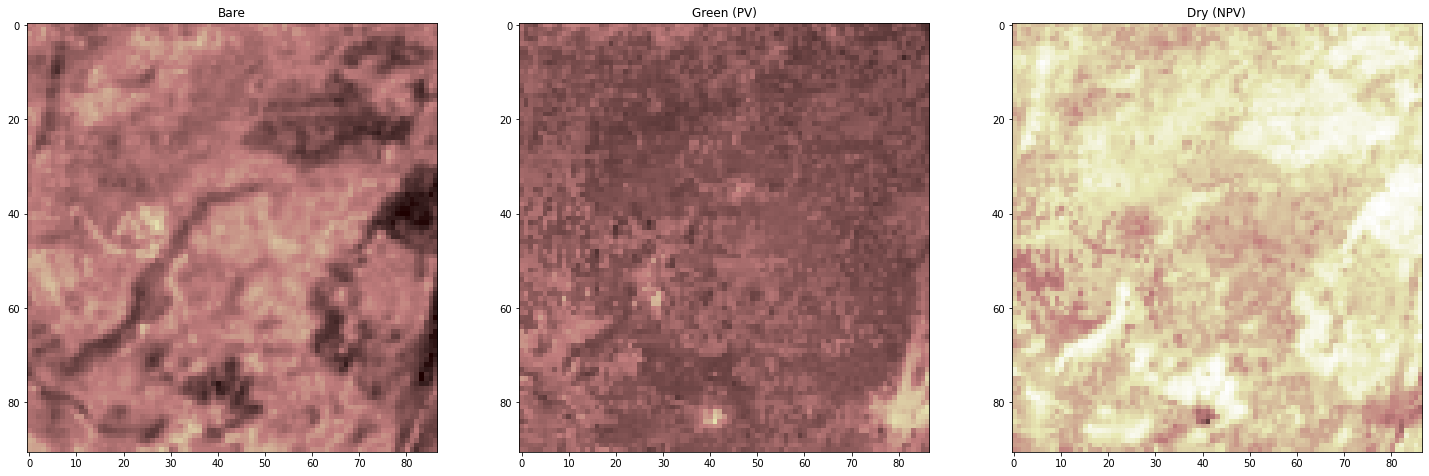

In [11]:
_min, _max = np.amin(fractions), np.amax(fractions)
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 3, 1)
# Add the vmin and vmax arguments to set the color scale
ax.imshow(fractions[0], cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax.set_adjustable("box")
ax.autoscale(False)
ax.set_title("Bare")


ax2 = fig.add_subplot(1, 3, 2)
ax2.set_adjustable("box")
ax2.imshow(fractions[1], cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax2.autoscale(False)
ax2.set_title("Green (PV)")


ax3 = fig.add_subplot(1, 3, 3)
ax3.set_adjustable("box")
ax3.imshow(fractions[2], cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax3.autoscale(False)
ax3.set_title("Dry (NPV)")


plt.show()

How does this compare with the pre-built version? These won't be exactly the same, since the prediction above is a single prediction from a seasonal surface reflectance composite image. The pre-built version is a composite of many single date fractional cover images.  So there may be some differences, but they should be similar.

In [12]:
with rio.open(
    "http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover_v3/fractional_cover/seasonal/nsw/lztmre_nsw_m202112202202_dp1a2.tif"
) as fh:
    mytrans = fh.transform
    mycrs = fh.crs
    # get the bounds in the correct coordinates
    # and find the window
    mywindow = from_bounds(*features.bounds(aoi_df.to_crs(mycrs)), mytrans)
    nrow = int(mywindow.height)
    ncol = int(mywindow.width)
    fcv3 = fh.read(window=mywindow)

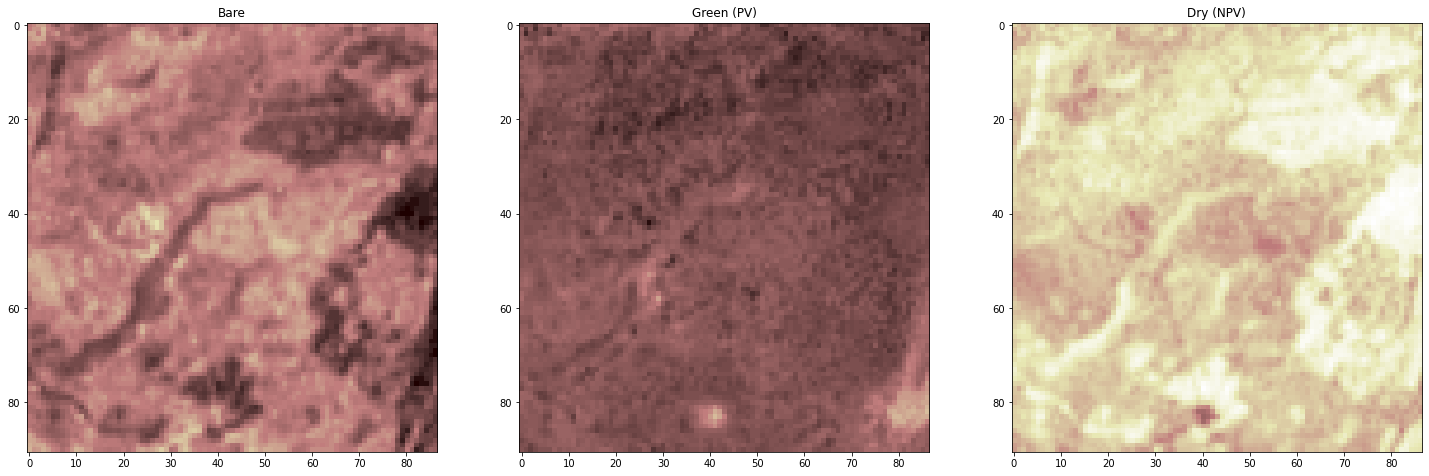

In [13]:
_min, _max = np.amin(fractions), np.amax(fractions)
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 3, 1)
# Add the vmin and vmax arguments to set the color scale
ax.imshow(fcv3[0] * 0.01, cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax.set_adjustable("box")
ax.autoscale(False)
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_adjustable("box")
ax2.imshow(fcv3[1] * 0.01, cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax2.autoscale(False)
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_adjustable("box")
ax3.imshow(fcv3[2] * 0.01, cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax3.autoscale(False)

ax.set_title("Bare")
ax2.set_title("Green (PV)")
ax3.set_title("Dry (NPV)")

plt.show()

# Predicting on Sentinel 2 Data

The model was trained on Landsat data, since the bulk of the field data was collected before sentinel 2 data was available. It is still possible to  predict cover using Sentinel 2. JRSRP method first adjusts the S2 surface reflectance to be similar to surface reflectance from landsat 7 (the base for our model training), and then predict as if the reflectance was sentinel 2.

In [14]:
with rio.open(
    "http://qld.auscover.org.au/public/data/sentinel2/surface_reflectance/nsw/cvmsre_nsw_m202112202202_abma2.tif"
) as fh:
    mytrans = fh.transform
    mycrs = fh.crs
    # get the bounds in the correct coordinates
    # and find the window
    mywindow = from_bounds(*features.bounds(aoi_df.to_crs(mycrs)), mytrans)
    profile = fh.profile
    nrow = int(mywindow.height)
    ncol = int(mywindow.width)
    ref = fh.read(window=mywindow)

In [15]:
refscaled = np.where(ref == profile["nodata"], -1, ref * 0.001)

In [16]:
def fudgeSen2toLandsat_sfcRef(refimage, outputSensor, nullVal, inputSensor="A"):
    """
    Convert Sentinel-2 surface reflectance values to look like Landsat
    surface reflectance. Can fudge to either Landsat-7 ETM+ or Landsat-8 OLI,
    depending on the value of outputSensor (either 7 or 8). There is no
    coincident data between Sentinel-2 and Landsat-5, for obvious reasons.

    The inputSensor defaults to 'A', for S2A, but after S2B is launched, we will
    check how comparable they are, and might need to fit further fudges, or something.

    This is an empirical fudge, derived from matching pairs of coincident cloud-free
    imagery from the two sensor, across large parts of Australia (Qld,NSW,Vic,NT), up to
    2017-01-31.

    The input should be Sentinel-2 surface reflectance, in the range [0,1], i.e. it has been
    unscaled back to physical units. It is assumed that the two pixel sizes have already
    been combined, and only the corresponding bands selected. The input array can have
    somewhat arbitrary shape, but the first dimension must be the band, and must be of
    length 6, i.e. the shape of the array is (6, ....).

    The shape is preserved on output. The output values are also reflectance values, but
    fudged to be more like Landsat values.

    Null values in the input are copied across to the output.

    """
    nBands = 6

    if refimage.shape[0] != nBands:
        raise ValueError(
            "Input array must have {} bands, this has {}".format(
                nBands, refimage.shape[0]
            )
        )

    # Univariate model coefficients
    if outputSensor == 7 and inputSensor == "A":
        c0 = [-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]
        c1 = [0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]
    elif outputSensor == 8 and inputSensor == "A":
        c0 = [-0.0012, 0.0013, 0.0027, 0.0147, 0.0025, -0.0011]
        c1 = [0.963, 1.0473, 0.9895, 1.0129, 0.9626, 0.9392]
    else:
        msg = "Input sensor '{}' and output sensor '{}' is not a known combination".format(
            inputSensor, outputSensor
        )
        raise ValueError(msg)

    outRef = []
    for i in range(nBands):
        fudged = c0[i] + c1[i] * refimage[i]
        fudged = fudged.clip(0, 1)
        outRef.append(fudged)

    outImage = np.array(outRef)

    nullMask = refimage == nullVal
    outImage[nullMask] = nullVal
    return outImage

In [17]:
refl7 = fudgeSen2toLandsat_sfcRef(refscaled, 7, -1)

In [18]:
tffractions = unmix_fractional_cover(refl7, fc_model=data.get_model())
fcLayers = np.clip(tffractions, 0, 2)
fcLayerSum = fcLayers.sum(axis=0) + np.finfo("float32").eps
fractions = fcLayers / fcLayerSum
fractions[fractions > 1.0] = 1.0

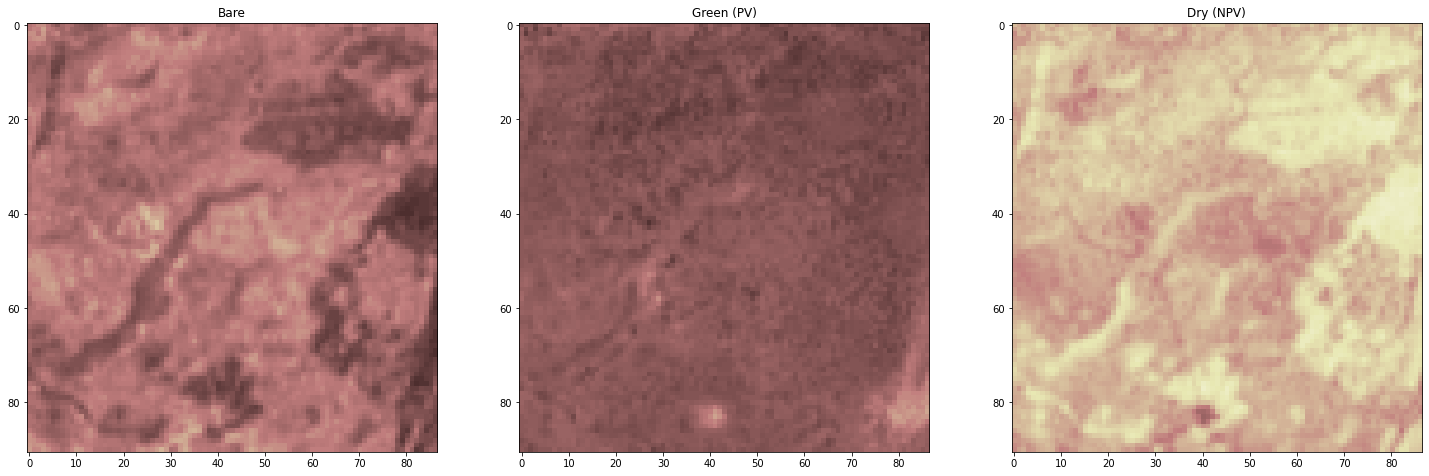

In [19]:
_min, _max = np.amin(fractions), np.amax(fractions)
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 3, 1)
# Add the vmin and vmax arguments to set the color scale
ax.imshow(fcv3[0] * 0.01, cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax.set_adjustable("box")
ax.autoscale(False)
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_adjustable("box")
ax2.imshow(fcv3[1] * 0.01, cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax2.autoscale(False)
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_adjustable("box")
ax3.imshow(fcv3[2] * 0.01, cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax3.autoscale(False)

ax.set_title("Bare")
ax2.set_title("Green (PV)")
ax3.set_title("Dry (NPV)")

plt.show()

## Comparing with Available Data
Actually not available for NSW. Will have to take my word for it that this is similar.